## Before you start this tutorial, get familiar with what an MD simulation looks like. You can look at the trajectory in this folder using the following command:
### Note: When you put a "!" at the beginning of a line in a jupyter notebook, it runs as if it was a BASH command. 

In [6]:
! /Applications/VMD\ 1.9.2.app/Contents/vmd/vmd_MACOSXX86 exampleProtein.pdb exampleTraj.dcd 

Info) VMD for MACOSXX86, version 1.9.2beta1 (September 12, 2014)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 4 CPUs detected.
Warning) Detected a mismatch between CUDA runtime and GPU driver
Warning) Check to make sure that GPU drivers are up to date.
Info) No CUDA accelerator devices available.
Info) OpenGL renderer: NVIDIA GeForce GT 330M OpenGL Engine
Info)   Features: STENCIL MDE CVA MTX NPOT PP PS GLSL(OVF) 
Info)   Full GLSL rendering mode is available.
Info)   Textures: 2-D (8192x8192), 3-D (2048x2048x2048), Multitexture (8)
Info) Dynamically loaded 2 plugins in directory:
Info) /Applicatio

### Note that, in VMD, we have to specify two files -- One containing the "topology" of the system (in this case a PDB file), which contains (at least) a listing of what atoms are present, what elements those atoms are, and how they are bonded. After that, we provide a "trajectory" file, or a compressed file containing X,Y,Z information about where each atom is in each simulation snapshot.

#### In addition to the elements and bonds, a PDB file contains a set of coordinates. This information goes beyond what is strictly expected in a "topology". If you want to view a stationary protein, a PDB file will suffice. Later you will learn about protein files like PRMTOPs that contain atoms and bonds, but no coordinates.

### One fairly advanced analysis that we can perform is a "water residence" analysis. This asks which waters stick around the protein for a while. We know that waters play a very important role in protein function, because when proteins are put in environments other than water (ethanol, benzene, or air), they behave differently.

In [1]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

### We load the trajectory using a topology file (in this case a pdb) and a trajectory file (the dcd)

In [2]:
traj = md.load('exampleTraj.dcd', top='exampleProtein.pdb')

### And get the number of frames in our trajectory

In [3]:
numFrames = len(traj)

### Prepare a list to contain the atom numbers of each first shell water's oxygen in each frame

In [4]:
firstShells = []

proteinSelection = traj.topology.select('protein')
waterSelection = traj.topology.select('water and name O')

### Use an MDTraj function to run through the trajectory and identify all the water oxygens within 2 angstroms of the protein.

In [5]:
watersNearProtein = md.compute_neighbors(traj, 
                                         0.2, 
                                         proteinSelection,
                                         haystack_indices=waterSelection)

### For each frame that was analyzed, put the water oxygen IDs into a set.

In [6]:
watersNearProtein = [set(i) for i in watersNearProtein]

### Walk through the waters near the protein in each frame (called the "first hydration shell"), and see how many of them are close in other frames. Make a (numFrames x numFrames) matrix with the number of first-shell waters that different frames have in common

In [7]:
firstOverlapMat = np.zeros((numFrames, numFrames))
for i in range(numFrames):
    for j in range(i, numFrames):
        overlap = len(watersNearProtein[i] & watersNearProtein[j])
        firstOverlapMat[i,j] = overlap
        firstOverlapMat[j,i] = overlap

### Use PyPlot to show what the first shell overlap matrix looks like

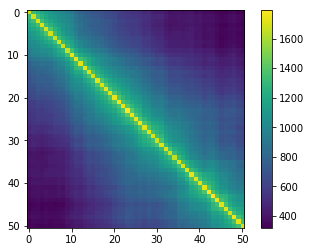

In [10]:
plt.imshow(firstOverlapMat)
plt.colorbar()
plt.show()

### What does this mean? What are the yellow points and the purple? Why is there a diagonal yellow line?

### Prepare a numpy array to hold the frame-to-frame similarity values

In [ ]:
firstOverlapMat = np.zeros((numFrames, numFrames))
nLeftList = []
nStayedList = []

### Now we go through each frame and compare it to the one right after it. We will use sets to do a handy task: Subtraction of two sets gives us a new set containing the items that are in one set and not another (difference). We will also use the "&" (intersection) operator, which returns a new set containing the items that both sets have in common. By counting how many items are in the difference and intersection, between every frame and the frame after it, we can count how many waters stay and leave each step.

In [ ]:
for frameIndex in range(numFrames-1):

    watersThatLeft = watersNearProtein[frameIndex] - watersNearProtein[frameIndex+1]
    # And the len() of a set is the number of items in it
    numWatersThatLeft = len(watersThatLeft)
    # The & operator returns items which appear in both 
    watersThatStayed = watersNearProtein[frameIndex] & watersNearProtein[frameIndex+1]
    numWatersThatStayed = len(watersThatStayed)
    
    print '%i waters left the first shell this frame, and %i stayed' %(numWatersThatLeft,numWatersThatStayed)

    # Store the results in a list
    nLeftList.append(numWatersThatLeft)
    nStayedList.append(numWatersThatStayed)

### And now we can use the PyPlot module to plot them

In [ ]:
plt.plot(nLeftList,label='Number of waters that left')
plt.plot(nStayedList,label='Number of waters that stayed')
plt.legend()
plt.show()


### There is an ATP molecule bound to this protein. 